In [78]:
#importing libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')

In [79]:
df=pd.read_csv("PJME_hourly.csv")


In [80]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [81]:
df=df.set_index('Datetime')

In [82]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [83]:
df.index=pd.to_datetime(df.index)

In [84]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

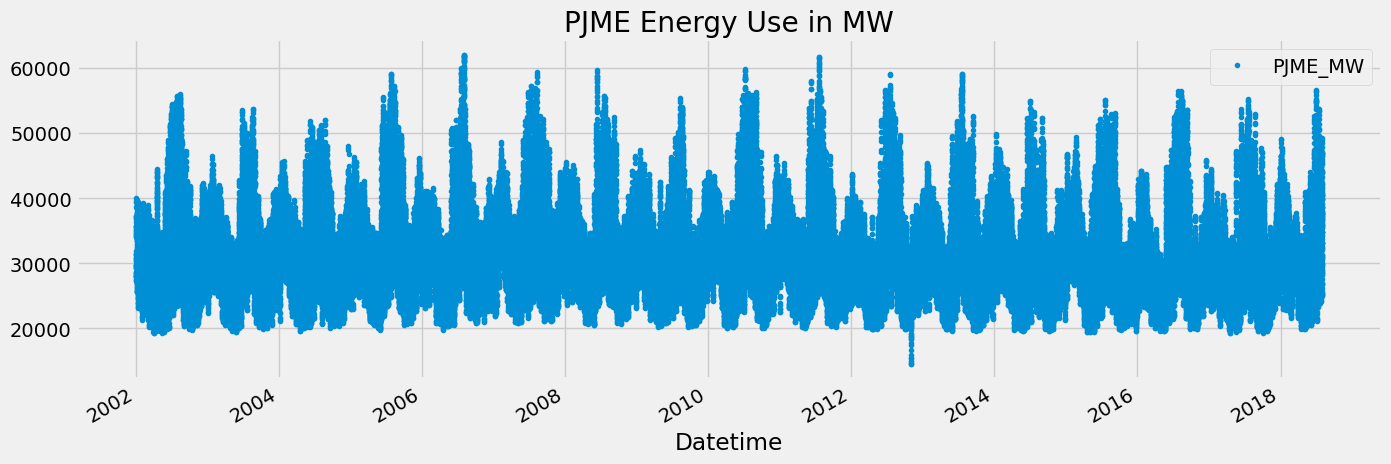

In [85]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Outlier analysis and removal 
around 2013 there might have been a black out or the sensor might not have worked

<Axes: ylabel='Frequency'>

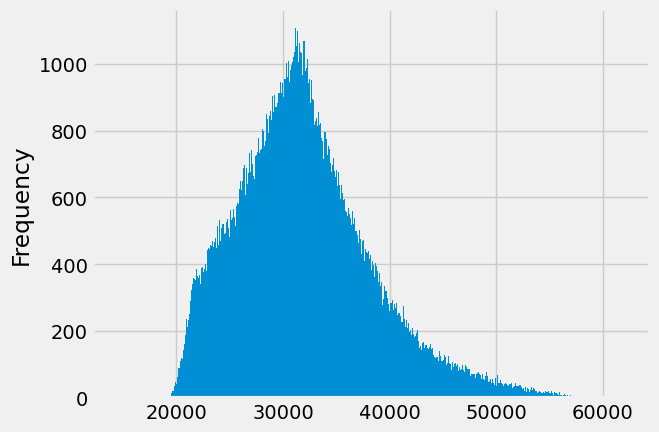

In [86]:
df['PJME_MW'].plot(kind='hist',bins=500)

most of the values are between 20000 and 50000, but we are looking for any extreme outliers that we would want to remove 

<Axes: xlabel='Datetime'>

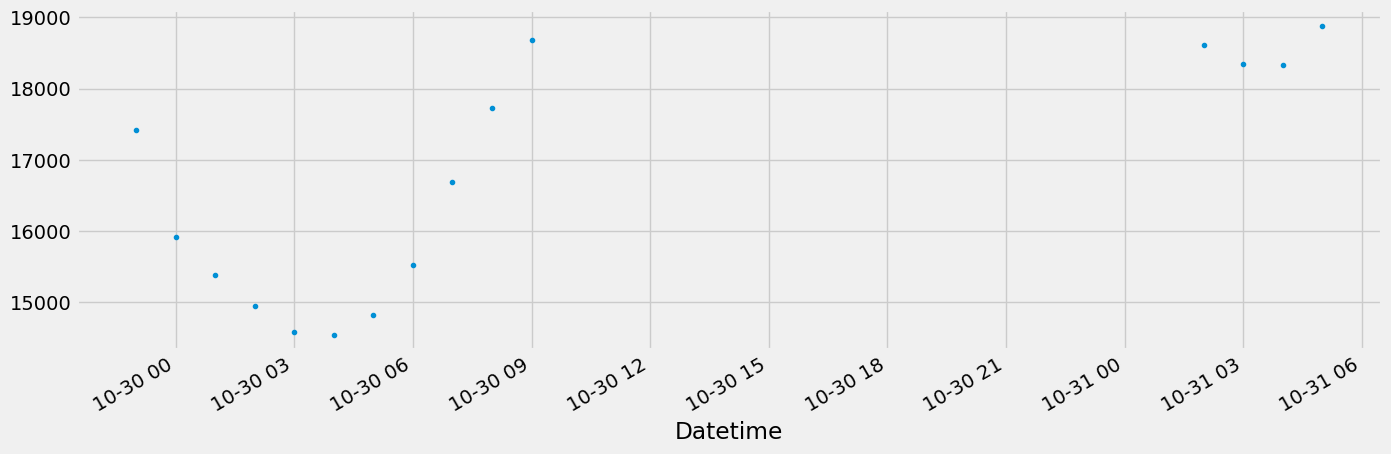

In [87]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(figsize=(15,5),style='.')

So, there are values less than 19000 and we would want to remove these from our training and validation set

In [88]:
df=df.query('PJME_MW > 19_000').copy()

Time Series Cross Validation: a more robust way to split data

In [89]:
from sklearn.model_selection import TimeSeriesSplit
# we have hourly energy consumption and lets assume we want to predict out into  one year ahead into future ,test_size = 24 hours x 365 days x 1 year
tss= TimeSeriesSplit(n_splits=5 ,test_size =24*365*1, gap=24)#gap between the training and validation set you're splitting on each time ,gap =24 hours 
#important to sort dataframe , otherwise timeseriesplit will not work 
df=df.sort_index()

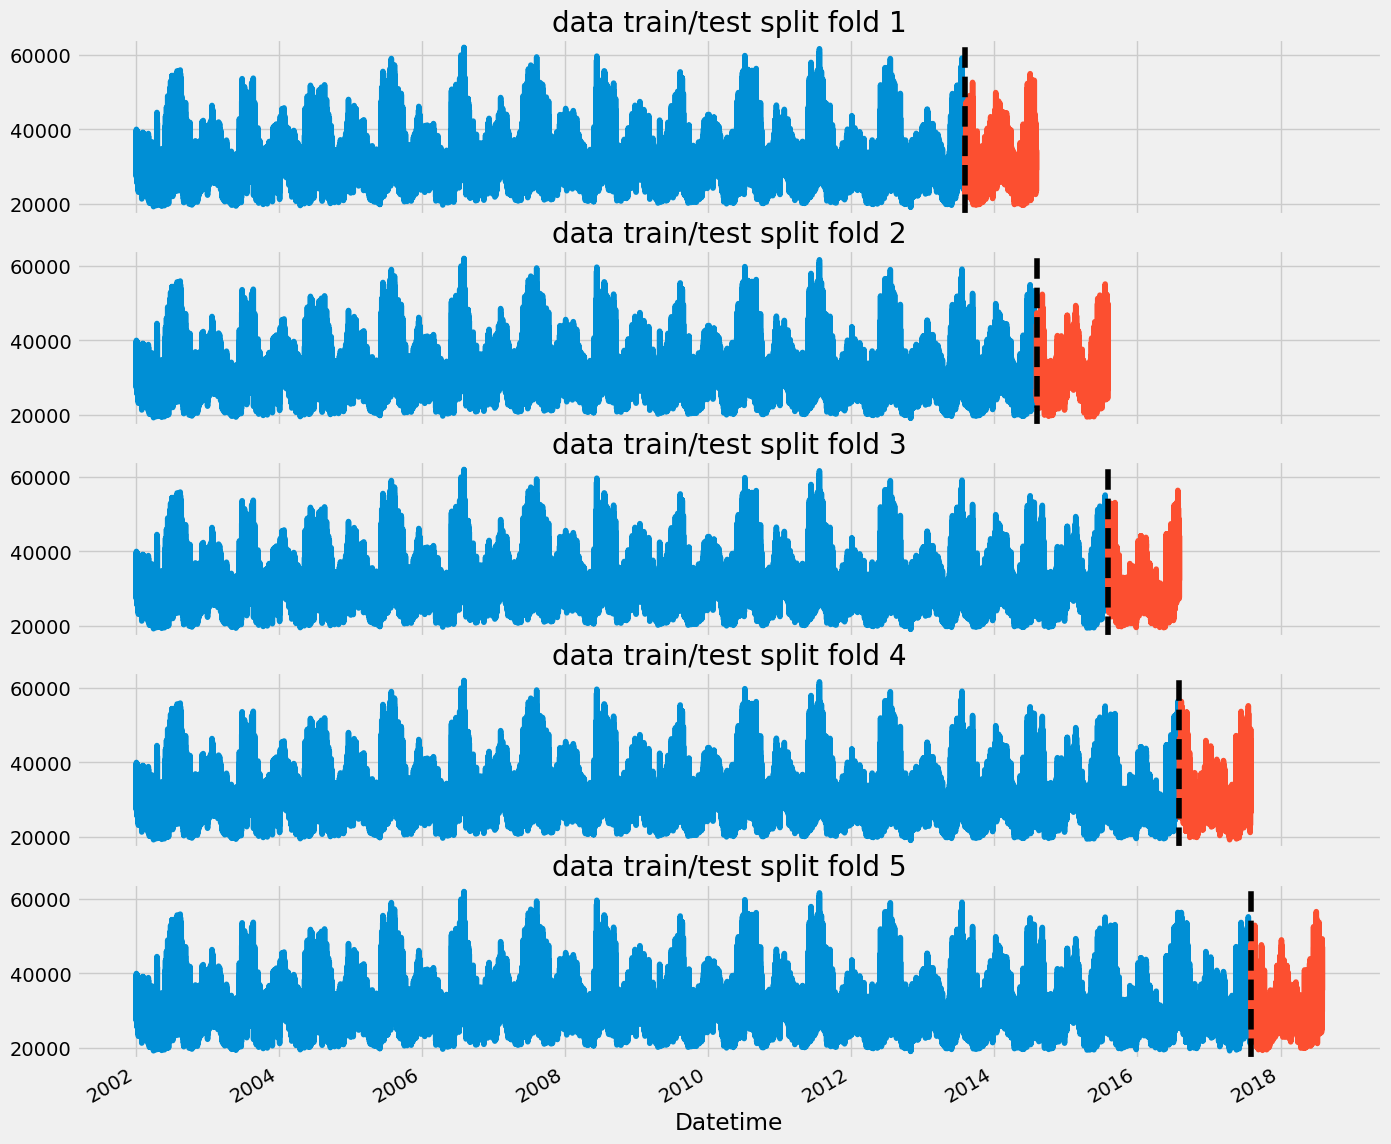

In [90]:
#visualizing the splits

fig, axs = plt.subplots(5,1,figsize=(15,15),sharex=True)
fold =0
for train_idx, val_idx in tss.split(df):
    train=df.iloc[train_idx]
    test=df.iloc[val_idx]

    train['PJME_MW'].plot(ax=axs[fold],
                          label='training set',
                          title=f'data train/test split fold {fold+1}')
    
    test['PJME_MW'].plot(ax=axs[fold],
                         label='test set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold += 1
plt.show()    


Its going back in time and we have one year of our validation set in each fold.
because of a lot of training data going way back into history ,testing each of the last 5 years for 5 different times is not an issue 



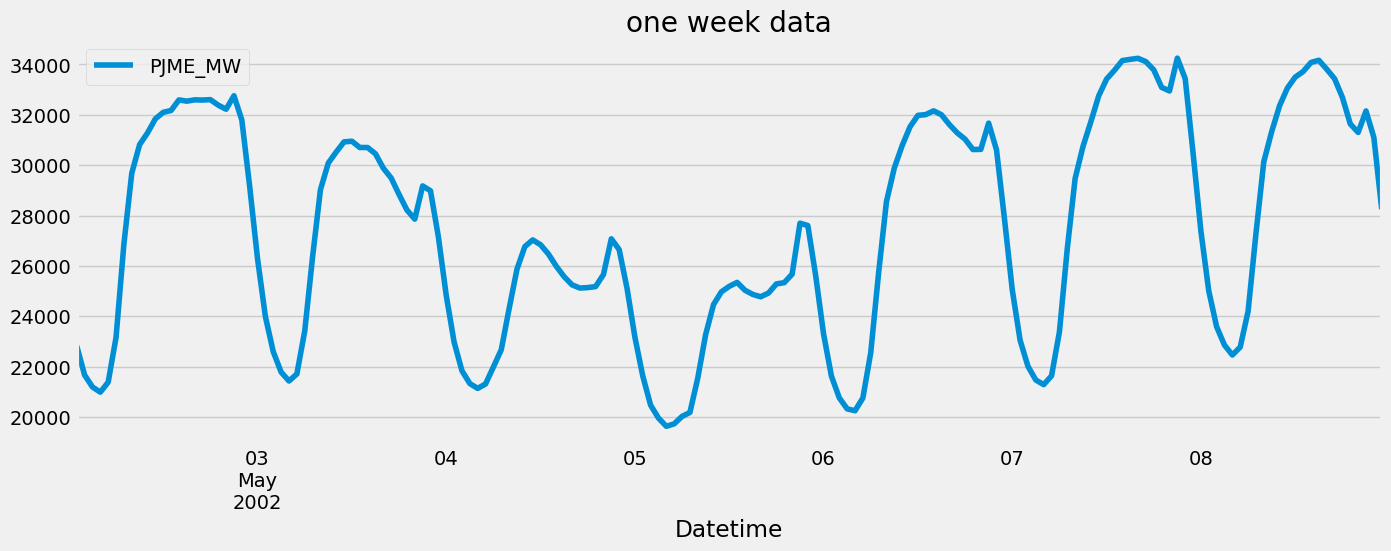

In [91]:
#looking at 1 week of data
#its recommended to use the 'yyyy-mm-dd'
df.loc[(df.index>'2002-05-02')&(df.index<'2002-05-09')].plot(figsize=(15,5),title="one week data")
plt.show()

Forecasting Horizon
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).
the farther into future the predcition is , the more difficult it is to achieve higher accuracy

In [92]:
#feature creation
def create_features(df):

    df = df.copy()  
    df['hour']=df.index.hour
    df['day_of_week']=df.index.day_of_week # monday=0 ,sunday =6
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['day_of_year']=df.index.day_of_year
    df['day_of_month']=df.index.day
    df['week_of_year']=df.index.isocalendar().week
    return df

In [93]:
df=create_features(df)
df

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31


lag features:
essentially telling the model to look back into the past for certain period in time and to use the target value for that period in the past as a new feature that is fed in the model 

lag feature should not be longer than your forecasting horizon 


In [134]:
# creating a dictionary for the target PJME_MW , to use for mapping lag features onto our dataframe
def add_lags(df):
    target_map=df['PJME_MW'].to_dict()
    #defining time delta viz some days into the past from our index day
    #lag1 is a one year lag variable
    df['lag1']=(df.index - pd.Timedelta('364 days')).map(target_map)# using 364/7 =52 , and it will give the exact day of the week 
    #lag2 is a 2 year LV
    df['lag2']=(df.index - pd.Timedelta('728 days')).map(target_map)
    #lag3 is a 3 year LV
    df['lag3']=(df.index - pd.Timedelta('1092 days')).map(target_map)
    return df



In [135]:
df=add_lags(df)
df.head()# there are no values of lag for earlier years 

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isfuture
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False


In [136]:
df.tail()# values are present 

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isfuture
Datetime,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,False
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,False
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,False
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0,False
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,False


In [137]:
df.loc['2003-08-02 20:00:00']

PJME_MW         41023.0
hour                 20
day_of_week           5
quarter               3
month                 8
year               2003
day_of_year         214
day_of_month          2
week_of_year         31
lag1            42988.0
lag2                NaN
lag3                NaN
isfuture          False
Name: 2003-08-02 20:00:00, dtype: object

In [138]:
df.loc['2002-08-02 20:00:00']

PJME_MW         50838.0
hour                 20
day_of_week           4
quarter               3
month                 8
year               2002
day_of_year         214
day_of_month          2
week_of_year         31
lag1                NaN
lag2                NaN
lag3                NaN
isfuture          False
Name: 2002-08-02 20:00:00, dtype: object

Train using Cross validation

In [139]:
from sklearn.metrics import mean_squared_error
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES=['hour','day_of_week','quarter','month','year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[12:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12534.39016	validation_1-rmse:11912.87340
[200]	validation_0-rmse:5761.39279	validation_1-rmse:5374.82731
[300]	validation_0-rmse:3904.90091	validation_1-rmse:3914.01161
[400]	validation_0-rmse:3471.17261	validation_1-rmse:3785.14723
[444]	validation_0-rmse:3407.27514	validation_1-rmse:3790.64564
[12:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12515.20147	validation_1-rmse:12226.31150
[200]	validation_0-rms

In [140]:
print(f'score across fold {np.mean(scores):0.4f}')
print(f'fold scores:{scores}')

score across fold 3746.8461
fold scores:[3782.4549274580972, 3452.0545993560495, 3529.966844224359, 4034.1135429087553, 3935.640511149801]


Predicting into the Future
we need to create a skeleton frame of dates we want to predict

In [141]:
#retrain on all data
df= create_features(df)

FEATURES=['hour','day_of_week','quarter','month','year','lag1','lag2','lag3']
TARGET = 'PJME_MW'
X_all = df[FEATURES]
y_all=df[TARGET]

reg=xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=500,
    learning_rate=0.01,
    max_depth=3,
                    )

reg.fit(X_all,y_all,
        eval_set=[(X_all,y_all)],
        verbose=100
        )

[0]	validation_0-rmse:32403.90575
[100]	validation_0-rmse:12428.77904
[200]	validation_0-rmse:5759.79698
[300]	validation_0-rmse:3995.18478
[400]	validation_0-rmse:3602.09302
[499]	validation_0-rmse:3493.10319


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [142]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [143]:
#create future dataframe
future=pd.date_range('2018-08-03','2019-08-01',freq='1h')#freq='1h' as we are predicting hourly
future_df=pd.DataFrame(index=future)
#to identify which values are future and which ones are not
future_df['isfuture']=True
df['isfuture']=False
df_and_future=pd.concat([df,future_df])


In [144]:
df_and_future

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isfuture
2002-01-01 01:00:00,30393.0,1.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True


In [145]:
df_and_future=create_features(df_and_future)
df_and_future=add_lags(df_and_future)

In [146]:
df_and_future

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isfuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [147]:
#extracting just future data and copying it
future_w_features= df_and_future.query('isfuture').copy()
future_w_features

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isfuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


Predict the future


In [148]:
future_w_features[FEATURES]

,hour,day_of_week,quarter,month,year,lag1,lag2,lag3
2018-08-03 00:00:00,0,4,3,8,2018,33539.0,32094.0,31695.0
2018-08-03 01:00:00,1,4,3,8,2018,30781.0,29503.0,29128.0
2018-08-03 02:00:00,2,4,3,8,2018,29015.0,27712.0,27373.0
2018-08-03 03:00:00,3,4,3,8,2018,27884.0,26535.0,26233.0
2018-08-03 04:00:00,4,4,3,8,2018,27223.0,25870.0,25643.0
...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,20,2,3,7,2019,46912.0,39352.0,40243.0
2019-07-31 21:00:00,21,2,3,7,2019,45985.0,38699.0,39183.0
2019-07-31 22:00:00,22,2,3,7,2019,44094.0,37346.0,37759.0
2019-07-31 23:00:00,23,2,3,7,2019,40666.0,34555.0,34641.0


In [149]:
future_w_features['pred']=reg.predict(future_w_features[FEATURES])

In [150]:
future_w_features

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isfuture,pred
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True,30637.482422
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True,28501.144531
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True,27973.775391
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True,27373.632812
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True,27041.525391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True,42125.148438
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True,41408.535156
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True,40482.175781
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True,38122.656250


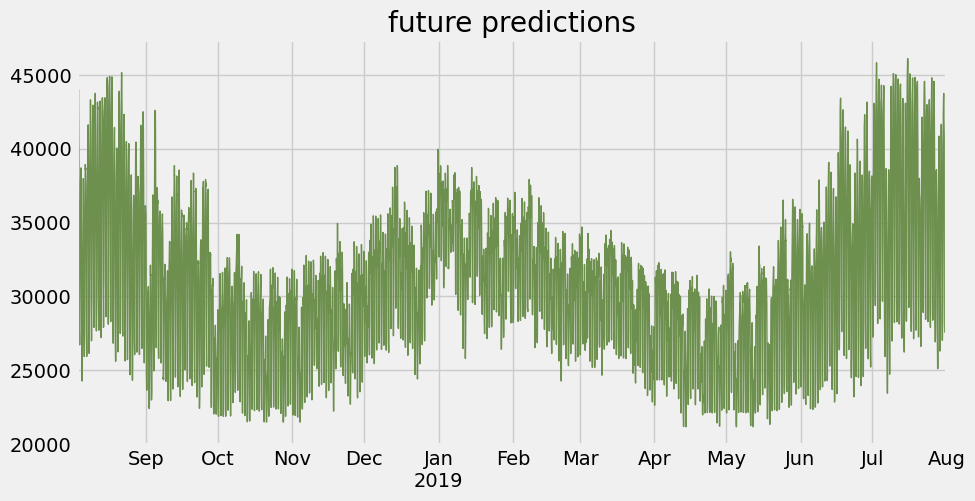

In [151]:
future_w_features['pred'].plot(
    figsize=(10, 5),color=color_pal[3],
    ms=1,lw=1,
    title='future predictions')
plt.show()    

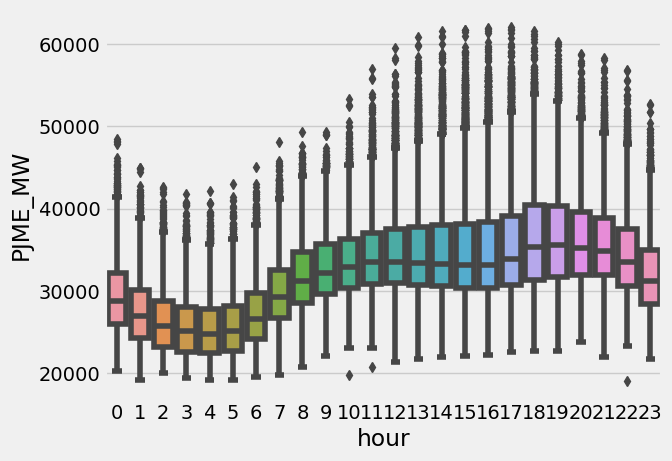

In [152]:
#visualize  feature /target relationship using seaborn's box plots
#boxplots gives an idea about the distribution of dataset
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

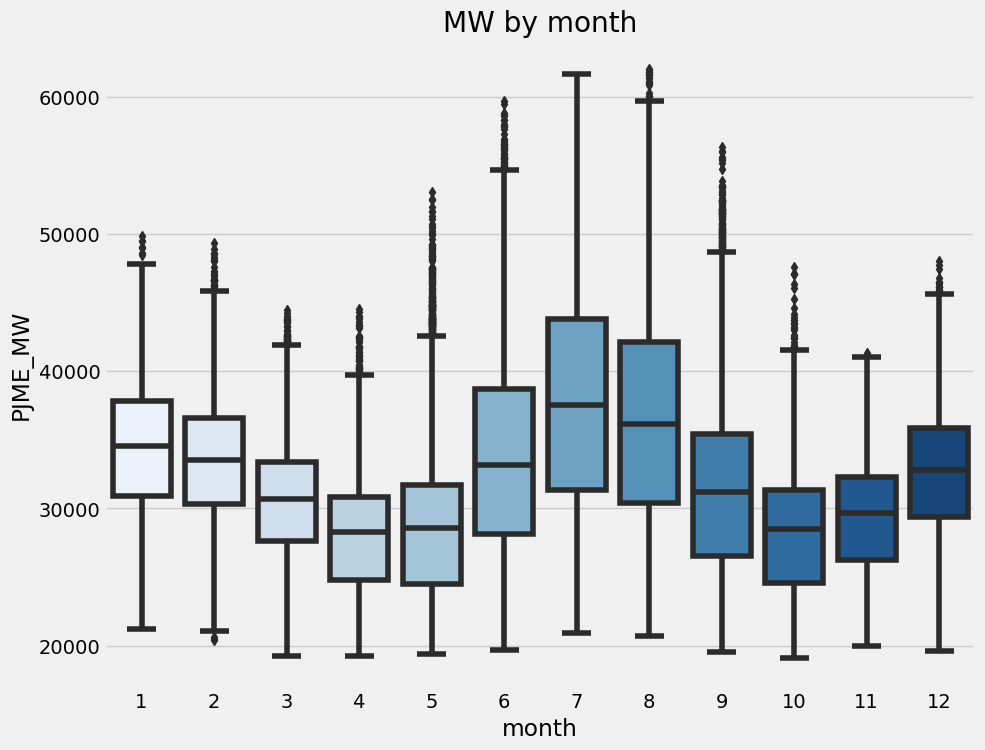

In [153]:
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df ,x='month',y='PJME_MW',palette='Blues')
ax.set_title('MW by month')
plt.show()

In [154]:
#Feature Importance : gives us importance values based on how much these features were used in each of the trees built by the xgb model
reg.feature_importances_ # these values by themselves arent very helpful

array([0.07149609, 0.02710758, 0.03842257, 0.03204986, 0.01609972,
       0.47275043, 0.24321982, 0.09885392], dtype=float32)

In [155]:
#creating pd dataframe where the data is these feature importances
fi=pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)

In [156]:
fi.sort_values('importance')

,importance
year,0.016100
day_of_week,0.027108
month,0.032050
quarter,0.038423
hour,0.071496
lag3,0.098854
lag2,0.243220
lag1,0.472750


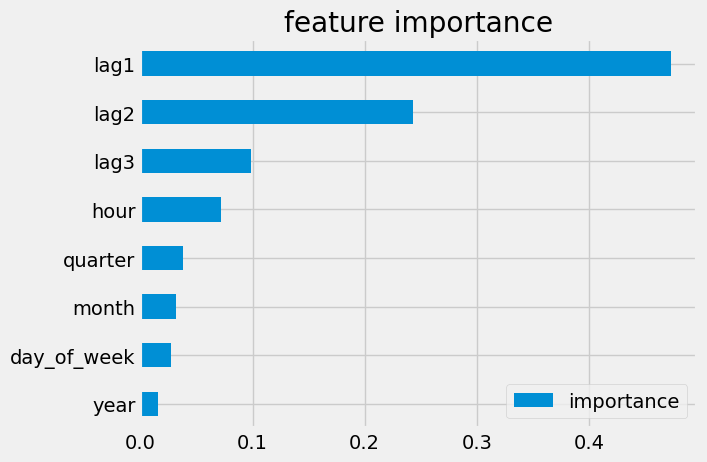

In [164]:
#ploting importance
fi.sort_values('importance').plot(kind='barh' , title='feature importance')
plt.show()

In [165]:
#when you have highly correalted features this feature importance functionality will not
#exactly tell how important each feature is individually but more so as a collective in this complete model

In [166]:
test['predictions']=reg.predict(X_test)

In [167]:
df1=df.merge(test['predictions'], how='left',left_index=True, right_index=True).dropna()
df1

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3,isfuture,predictions
Datetime,,,,,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,3,31,28809.0,29952.0,28465.0,False,28305.683594
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,3,31,27039.0,27934.0,26712.0,False,27550.501953
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,3,31,25881.0,26659.0,25547.0,False,26815.957031
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,3,31,25300.0,25846.0,24825.0,False,26169.388672
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,3,31,25412.0,25898.0,24927.0,False,26189.556641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,False,41239.171875
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,False,40318.386719
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,False,38968.414062


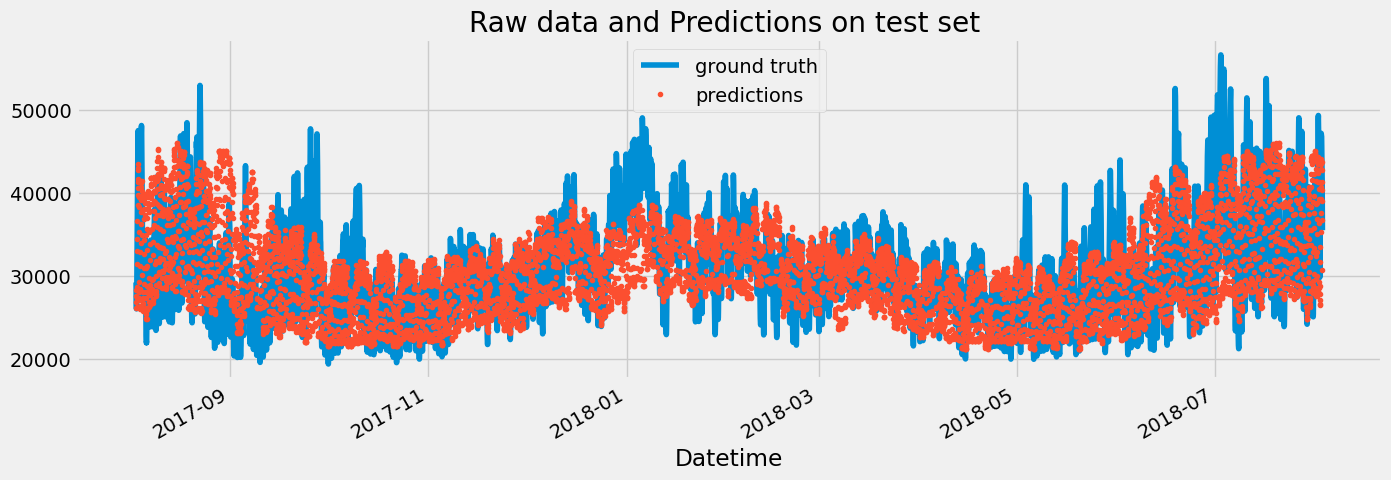

In [172]:
ax=df1['PJME_MW'].plot(figsize=(15,5))
df1['predictions'].plot(ax=ax,style='.')
plt.legend(['ground truth','predictions'])
ax.set_title('Raw data and Predictions on test set ')
plt.show()

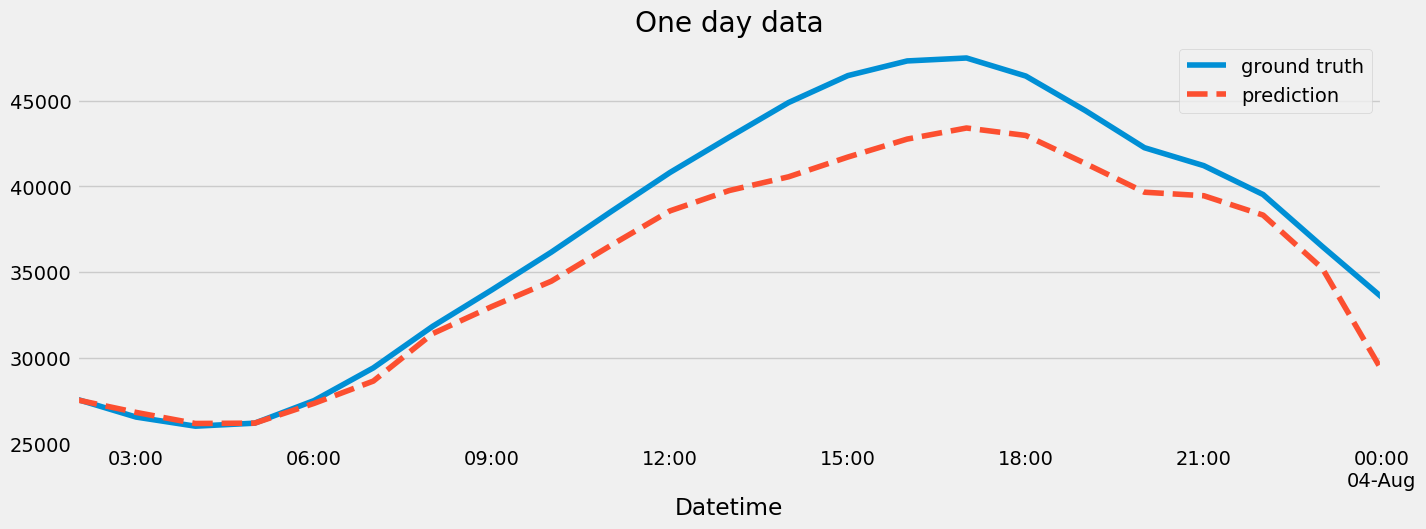

In [170]:
ax=df1.loc[(df1.index>'2017-08-03 01:00:00	 ')&(df1.index<'2017-08-4 01:00:00	')]['PJME_MW'].plot(figsize=(15,5),title='One day data')
df1.loc[(df1.index>'2017-08-03 01:00:00	')&(df1.index<'2017-08-4 01:00:00	')]['predictions'].plot(style='--')
plt.legend(['ground truth','prediction'])
plt.show()


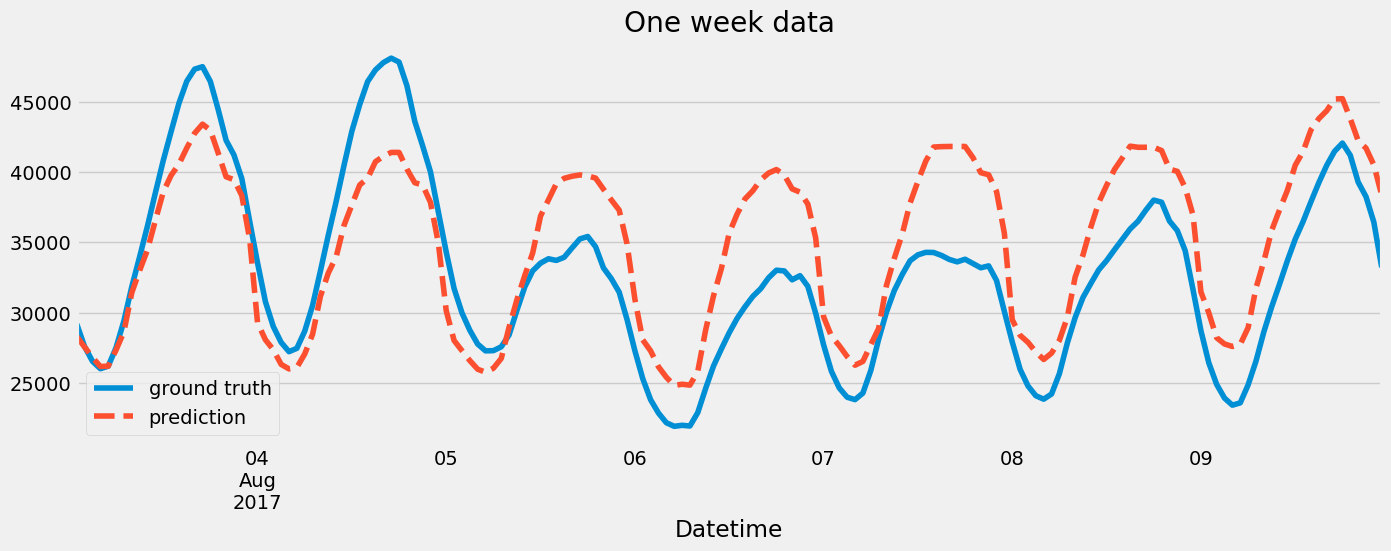

In [171]:
ax=df1.loc[(df1.index>'2017-08-03')&(df1.index<'2017-08-10')]['PJME_MW'].plot(figsize=(15,5),title='One week data')
df1.loc[(df1.index>'2017-08-03')&(df1.index<'2017-08-10')]['predictions'].plot(style='--')
plt.legend(['ground truth','prediction'])
plt.show()


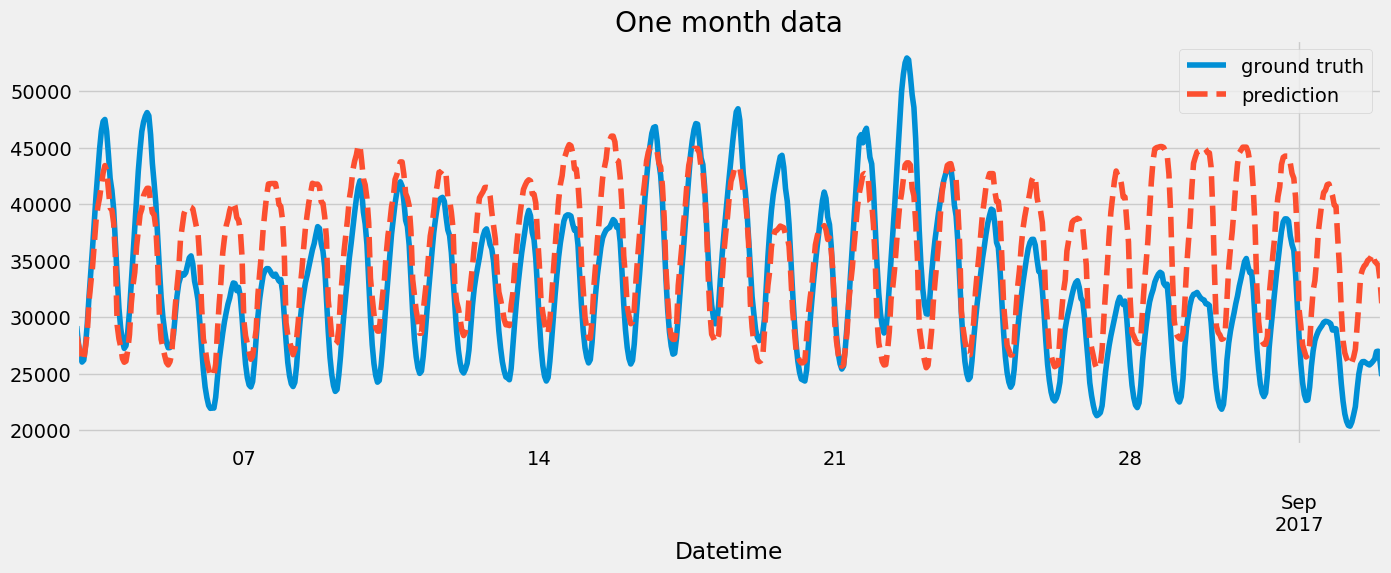

In [173]:
ax=df1.loc[(df1.index>'2017-08-03')&(df1.index<'2017-09-03')]['PJME_MW'].plot(figsize=(15,5),title='One month data')
df1.loc[(df1.index>'2017-08-03')&(df1.index<'2017-09-03')]['predictions'].plot(style='--')
plt.legend(['ground truth','prediction'])
plt.show()
